# Predicción de la demanda eléctrica
*Ignacio Díaz Blanco, 2019. Universidad de Oviedo*

Datos de demanda en UK tomados de http://www.gridwatch.templar.co.uk
En este ejemplo, se utiliza exclusivamente la información relativa
al "tipo de día" definido por:
1. la semana del año (0,1, ..., 52)
2. el día de la semana (lun, mar, ...)
3. la hora del día (0,1, ..., 23)

Se consideran consumos de horas anteriores (regresividad AR)
En principio, la estimación mejoraría añadiendo como datos
1. la temperatura
2. el tipo de día (fiestas nacionales, etc.)
3. determinados índices de actividad económica


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
datos = pd.read_csv('../../datos/datosConsumos.csv', header=None)
datos.columns = ['consumos', u'semana del año', u'día de la semana', u'hora del día']

In [3]:
# mostramos los 7 primeros registros
datos.head(7)

,consumos,semana del año,día de la semana,hora del día
0,38859.500000,21,4,15
1,38657.083333,21,4,16
2,37497.583333,21,4,17
3,36146.333333,21,4,18
4,34741.166667,21,4,19
5,34722.666667,21,4,20
6,33434.833333,21,4,21


In [4]:
C = datos['consumos'].values
W = datos[u'semana del año'].values
D = datos[u'día de la semana'].values
H = datos[u'hora del día'].values


In [5]:
# CREAMOS REGRESOR DINÁMICO (TAP-DELAY) DE DATOS DE ENTRENAMIENTO
X = []
y = []

# entrenamos con los datos de un año (8760 registros horarios) 
N = 8760

# estimamos los datos de varias horas después (ej. ahead = 24 horas) 
ahead = 24
for k in range(169,N):
    X.append(np.hstack((
                C[k-24:k-1],           # vector de consumo diario (24h)
                W[k],                  # semana del año
                D[k],                  # día de la semana
                H[k],                  # hora del día
                1                      # término independiente
            )).tolist()  )
    y.append(C[k+ahead].tolist() )

        
# CREAMOS REGRESOR DINÁMICO (TAP-DELAY) DE DATOS DE TEST
Xtst = []
ytst = []
Ntst = 10000

for k in range(169,Ntst):
    Xtst.append(np.hstack((
                C[k-24:k-1],           # vector de consumo diario (24h)          
                W[k],                  # semana del año
                D[k],                  # día de la semana
                H[k],                  # hora del día
                1                      # término independiente
            )).tolist()  )
    ytst.append(C[k+ahead].tolist() )


        

In [6]:
np.array(y)

array([33766.83333333, 33403.5       , 32363.        , ...,
       31718.83333333, 31893.5       , 31803.08333333], shape=(8591,))

In [7]:
X = np.array(X)
y = np.array(y)
Xtst = np.array(Xtst)
ytst = np.array(ytst)

print(X.shape,y.shape)

(8591, 27) (8591,)


In [8]:
# NORMALIZACIÓN DE LAS VARIABLES
from sklearn.preprocessing import MinMaxScaler

# Creamos una clase de normalización
minmaxx = MinMaxScaler(feature_range=(-1,1))

# Aplicamos método fit para calcular la normalización (hallar máximos y mínimos)
minmaxx.fit(X)

# Aplicamos la normalización a los datos de entrenamiento y a los de test
X_norm    = minmaxx.transform(X)
Xtst_norm = minmaxx.transform(Xtst)

# Creamos una clase de normalización para las salidas
minmaxy = MinMaxScaler(feature_range=(-1,1))

# Aplicamos método fit para calcular la normalización (hallar máximos y mínimos) 
minmaxy.fit(y[:,None])

# Aplicamos la normalización a los datos de entrenamiento y a los de test
y_norm    = minmaxy.transform(y[:,None]).ravel()
ytst_norm = minmaxy.transform(ytst[:,None]).ravel()

In [9]:
# LIMITES PARA LA REPRESENTACIÓN DE LOS RESULTADOS
xmin = 9000
xmax = 10000
ymin = -1
ymax = +1


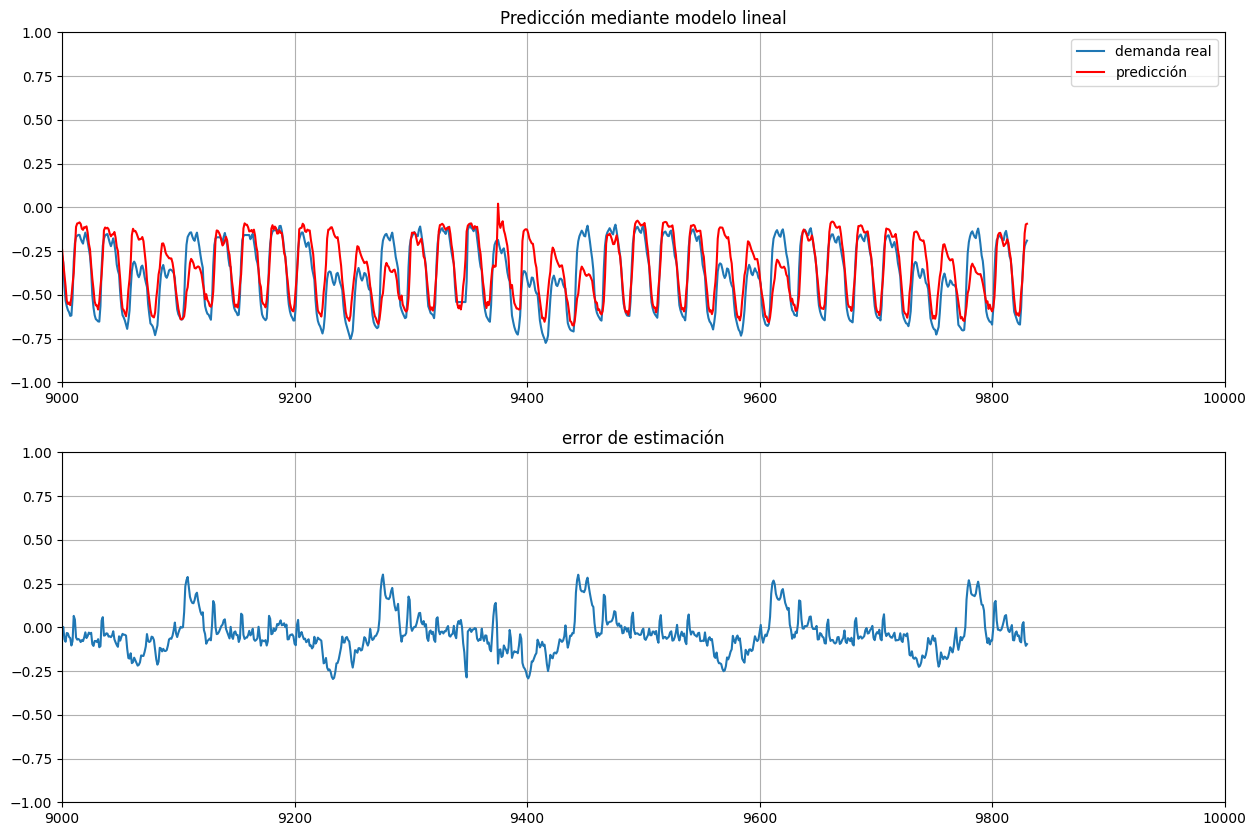

In [10]:
# PREDICCIÓN LINEAL
from sklearn import linear_model
clf = linear_model.Ridge (alpha = 0.1)
clf.fit(X_norm,y_norm)
yest_norm = clf.predict(Xtst_norm)


plt.figure(1,figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(ytst_norm)
plt.plot(yest_norm,'r')
plt.axis(xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax)
plt.axis(ymin=-1,ymax=1)
plt.grid(True)
plt.legend(['demanda real',u'predicción'])
plt.title('Predicción mediante modelo lineal')




plt.subplot(2,1,2)
plt.plot(ytst_norm-yest_norm)
plt.axis(xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax)
plt.title(u'error de estimación')
plt.axis(ymin=-1,ymax=1)
plt.grid(True)



In [11]:
(ytst_norm-yest_norm).shape

(9831,)

**Modelado usando Support Vector Regression (SVR)** 

In [12]:
# PREDICCIÓN Support Vector Regression (SVR)
from sklearn.svm import SVR
import numpy as np

# este método permite calcular los coeficientes de una aproximación rbf
# mediante una optimización "robusta". No está limitado a rbf. Es extensible a otros tipos de aproximaciones.
clf = SVR(kernel='rbf', gamma=.5, C=10, epsilon=.02)

**Inferencia utilizando el modelo SVR anterior**

In [13]:
clf.fit(X_norm,y_norm)
yest_norm = clf.predict(Xtst_norm)

**Demanda y predicción (valores normalizados)**

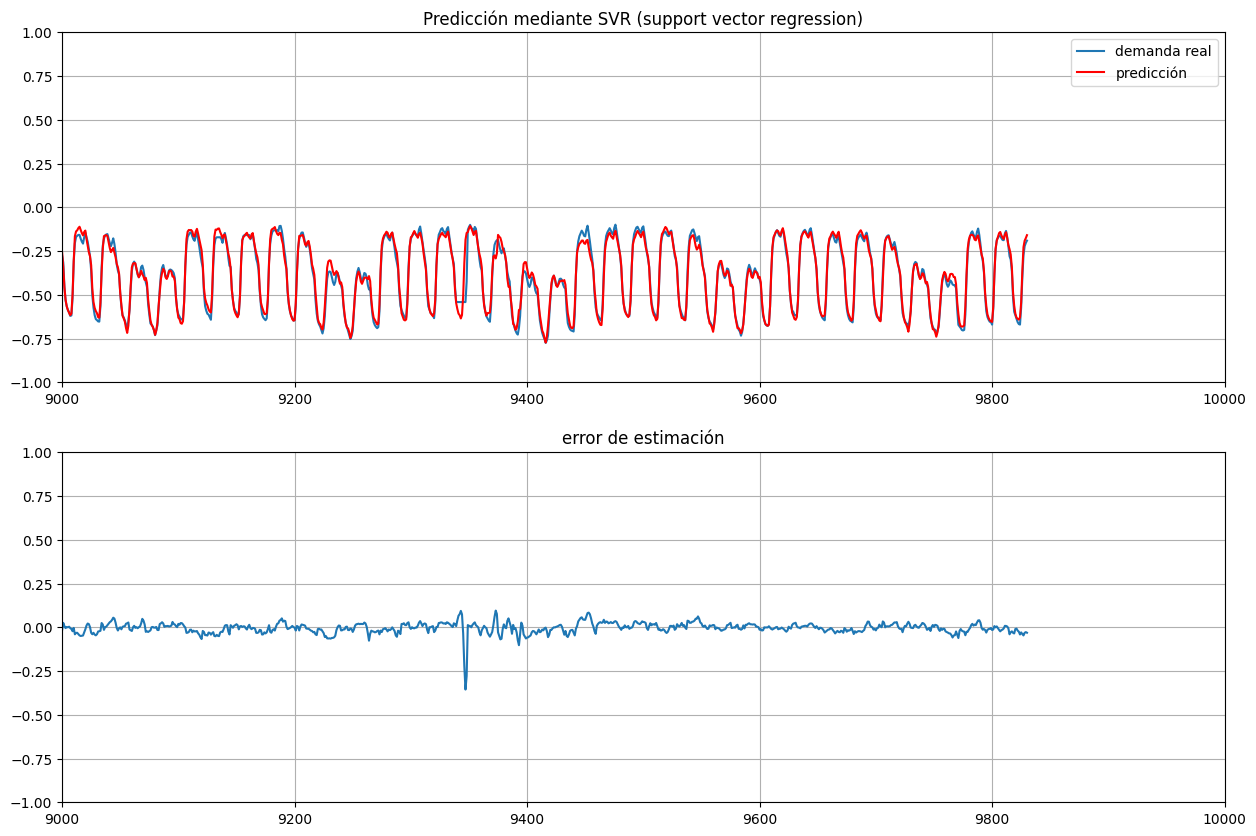

In [14]:
plt.figure(1,figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(ytst_norm)
plt.plot(yest_norm,'r')
plt.axis(xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax)
plt.grid(True)
plt.legend(['demanda real',u'predicción'])
plt.title('Predicción mediante SVR (support vector regression)')


plt.subplot(2,1,2)
plt.plot(ytst_norm-yest_norm)
plt.title(u'error de estimación')
plt.axis(xmin=xmin,xmax=xmax,ymin=ymin,ymax=ymax)
plt.grid(True)

**Demanda y predicción (escala real)**

Se aplica la transformación inversa de la normalización para obtener los valores de las demandas real y estimada en escala real

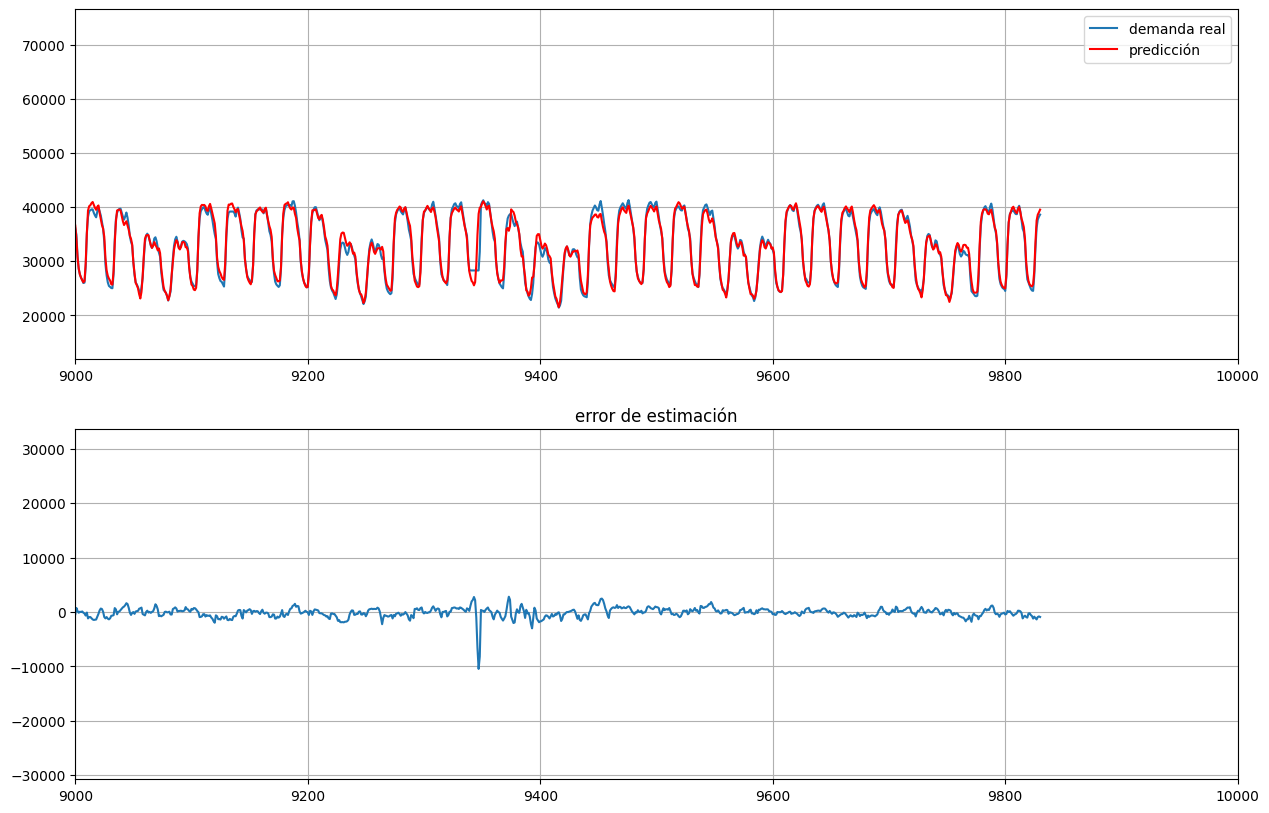

In [15]:
plt.figure(1,figsize=(15,10))
plt.subplot(2,1,1)
plt.plot(minmaxy.inverse_transform(ytst_norm[:,None]))
plt.plot(minmaxy.inverse_transform(yest_norm[:,None]),'r')
plt.axis(xmin=xmin,xmax=xmax)
plt.grid(True)
plt.legend(['demanda real',u'predicción'])


plt.subplot(2,1,2)
plt.plot(minmaxy.inverse_transform(ytst_norm[:,None])-minmaxy.inverse_transform(yest_norm[:,None]))
plt.title(u'error de estimación')
plt.axis(xmin=xmin,xmax=xmax)
plt.grid(True)


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br /><span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">Ejemplo de predicción de la demanda eléctrica</span> by <a xmlns:cc="http://creativecommons.org/ns#" href="http://isa.uniovi.es/~idiaz" property="cc:attributionName" rel="cc:attributionURL">Ignacio Díaz Blanco</a> is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Reconocimiento-CompartirIgual 4.0 Internacional License</a>.